In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
# MT5 Imports
import MetaTrader5 as mt5
from MetaTrader5 import AccountInfo, TerminalInfo
import importlib
importlib.reload(mt5)

<module 'MetaTrader5' from 'c:\\Users\\puche\\anaconda3\\Lib\\site-packages\\MetaTrader5\\__init__.py'>

In [3]:
import dotenv
import os
import importlib
import pandas as pd
import dask.dataframe as dd
from datetime import datetime
import logging

import naut_mt5 as n5
from naut_mt5 import data_utils

import nautilus_trader
# test instrument provider
from nautilus_trader.test_kit.providers import TestInstrumentProvider
from nautilus_trader.persistence.wranglers import QuoteTickDataWrangler
from nautilus_trader.persistence.catalog import ParquetDataCatalog


In [4]:
# ENVIRONMENT
if not dotenv.load_dotenv():
    logging.log(logging.INFO, "No .env file found")

dotenv.load_dotenv(override=True)
MT5_SERVER = os.environ["MT5_SERVER"]
MT5_LOGIN = os.environ["MT5_LOGIN"]
MT5_PASSWORD = os.environ["MT5_PASSWORD"]
DATA_PATH = os.environ["DATA_PATH"]
CATALOG_PATH = os.environ["CATALOG_PATH"]


print(f"MT5_SERVER: {MT5_SERVER}")


MT5_SERVER: ICMarketsSC-MT5-2


# Symbol Parameters

In [9]:
from nautilus_trader.model.identifiers import InstrumentId, Venue
from nautilus_trader.model.data import BarType, BarSpecification, BarAggregation
from nautilus_trader.model.data import QuoteTick

# load a couple of symbols into the catalog using the loader
symbol_broker = 'XAUUSD'
symbol_clean = 'XAUUSD'
venue= "SIM_IC"
instrument = TestInstrumentProvider.default_fx_ccy(symbol_clean, Venue(venue))
timeframe = mt5.TIMEFRAME_M1
start_date = datetime(1971, 1, 1)
end_date = datetime.now()

# variables dependent on parameters
if symbol_clean:
    symbol = symbol_clean
else:
    symbol = symbol_broker
    
loader_config = n5.MTLoginConfig(server=MT5_SERVER, login=MT5_LOGIN, password=MT5_PASSWORD)
loader = n5.MT5Loader(data_path=DATA_PATH, catalog_path=CATALOG_PATH, config=loader_config, venue=venue)
loader.init()

True

In [10]:
mt5.account_info().equity

93.95

# Delete the symbol from the catalog

In [13]:
# delete the symbols data from the catalog
bar_type = loader.get_bar_type(symbol, timeframe)
print(bar_type)

if not data_utils.delete_parquet_data(bar_type, CATALOG_PATH):
    print(f"INFO: Could not delete")
else:
    print(f"INFO: Deleted data for {bar_type}")
    
    

XAUUSD.SIM_IC-1-MINUTE-LAST-EXTERNAL
[WinError 3] Das System kann den angegebenen Pfad nicht finden: '.\\catalog\\data\\bar\\XAUUSD.SIM_IC-1-MINUTE-LAST-EXTERNAL'
INFO: Could not delete


# Load the symbol from mt5 to csv

In [14]:
loader.load_symbol_rates_to_csv(symbol_broker, symbol_clean, timeframe, start_date, end_date, DATA_PATH)

ERROR: Failed to copy rates: XAUUSD 1 1971-01-01 00:00:00 2024-12-01 13:22:54.019575


False

# Load the symbol from csv to parquet catalog

In [16]:
loader.load_csv_to_catalog(symbol_broker, symbol_clean, timeframe, start_date, end_date)

FileNotFoundError: [Errno 2] No such file or directory: '.\\data\\XAUUSD_1-MINUTE_31532400_1733055774.csv'

In [118]:
instrument = loader.get_instrument_FOREX(symbol=symbol)

# MT5 Ticks

In [17]:
from datetime import datetime
import MetaTrader5 as mt5
# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)
 
# import the 'pandas' module for displaying data obtained in the tabular form
import pandas as pd
pd.set_option('display.max_columns', 500) # number of columns to be displayed
pd.set_option('display.width', 1500)      # max table width to display
# import pytz module for working with time zone
import pytz
 
# establish connection to MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")
# create 'datetime' objects in UTC time zone to avoid the implementation of a local time zone offset
utc_from = datetime(2020, 1, 10, tzinfo=timezone)
utc_to = datetime(2020, 1, 11, hour = 13, tzinfo=timezone)
# get bars from USDJPY M5 within the interval of 2020.01.10 00:00 - 2020.01.11 13:00 in UTC time zone
rates = mt5.copy_rates_range("XAUUSD", mt5.TIMEFRAME_M1, utc_from, utc_to)
 
# shut down connection to the MetaTrader 5 terminal
mt5.shutdown()
 
# display each element of obtained data in a new line
print("Display obtained data 'as is'")
counter=0
for rate in rates:
    counter+=1
    if counter<=10:
        print(rate)
 
# create DataFrame out of the obtained data
rates_frame = pd.DataFrame(rates)
# convert time in seconds into the 'datetime' format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
 
# display data
print("\nDisplay dataframe with data")
print(rates_frame.head(10))

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4687
Display obtained data 'as is'
(1643967720, 1807.02, 1807.55, 1806.96, 1807.44, 138, 12, 0)

Display dataframe with data
                 time     open     high      low    close  tick_volume  spread  real_volume
0 2022-02-04 09:42:00  1807.02  1807.55  1806.96  1807.44          138      12            0


In [18]:
import MetaTrader5 as mt5

mt5.initialize()
maxbars = mt5.terminal_info().maxbars
for count in range(maxbars):
    rates = mt5.copy_rates_from_pos('XAUUSD', mt5.TIMEFRAME_M1, 0, 10000)
    errno, strerror = mt5.last_error()
    if errno != mt5.RES_S_OK:
        print(f"Failed on count={count} with strerror={strerror}")
        break
mt5.shutdown()

KeyboardInterrupt: 

In [ ]:
rates_frame = pd.DataFrame(rates)
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
rates_frame

,time,open,high,low,close,tick_volume,spread,real_volume
0,2024-11-20 13:22:00,2621.90,2621.99,2621.66,2621.93,78,18,0
1,2024-11-20 13:23:00,2621.93,2622.15,2621.68,2622.15,102,18,0
2,2024-11-20 13:24:00,2622.15,2622.94,2621.80,2622.86,104,18,0
3,2024-11-20 13:25:00,2622.86,2623.63,2622.76,2623.59,99,16,0
4,2024-11-20 13:26:00,2623.58,2623.94,2623.54,2623.73,102,18,0
...,...,...,...,...,...,...,...,...
9995,2024-11-29 21:40:00,2649.65,2649.65,2648.96,2649.25,94,32,0
9996,2024-11-29 21:41:00,2649.27,2649.42,2649.22,2649.38,46,32,0
9997,2024-11-29 21:42:00,2649.35,2650.16,2649.27,2650.16,105,31,0
9998,2024-11-29 21:43:00,2650.16,2650.22,2649.85,2650.02,85,32,0


In [ ]:
print(mt5.symbols_get("XAUUSD"))
print(mt5.account_info())

(SymbolInfo(custom=False, chart_mode=0, select=True, visible=True, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=1732916699, digits=2, spread=32, spread_float=True, ticks_bookdepth=1, trade_calc_mode=4, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=20, trade_freeze_level=0, trade_exemode=2, swap_mode=1, swap_rollover3days=3, margin_hedged_use_leg=False, expiration_mode=7, filling_mode=2, order_mode=127, order_gtc_mode=0, option_mode=0, option_right=0, bid=2650.3, bidhigh=2666.25, bidlow=2634.01, ask=2650.62, askhigh=2666.44, asklow=2634.22, last=0.0, lasthigh=0.0, lastlow=0.0, volume_real=0.0, volumehigh_real=0.0, volumelow_real=0.0, option_strike=0.0, point=0.01, trade_tick_value=0.94519745174767, trade_tick_value_profit=0.94519745174767, trade_tick_value_loss=0.9454744863709854, trade_tick_size=0.01, trade_contract_size=100.0, trade_accrued_interest=0.0, trade_face_value=0.0, trade_liquidity_rate=0.0, volume

In [ ]:
pos = mt5.positions_total()
print(pos)

5


In [ ]:
mt5.initialize()
ticks = mt5.copy_ticks_range("XAUUSD", datetime(2024,1,1), datetime(2024,1,1), mt5.COPY_TICKS_ALL)
df = pd.DataFrame(ticks)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.head()

SyntaxError: '(' was never closed (2983694969.py, line 2)

In [ ]:
data = loader.copy_rates_range("XAUUSD", timeframe, datetime(2023,1,1), datetime.now())

## Copy Rates to Disk

In [25]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime
import os

def download_and_save_data(symbol, timeframe, start_pos, num_bars, chunk_size, csv_filename, parquet_filename):
    # Initialize MetaTrader 5 connection
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        return
    
    # Create empty list to store rates
    all_rates = []
    
    # Check if files already exist
    csv_exists = os.path.exists(csv_filename)
    parquet_exists = os.path.exists(parquet_filename)
    
    # Download the data in chunks
    for i in range(0, num_bars, chunk_size):
        chunk_bars = min(chunk_size, num_bars - i)
        
        # Fetch the data for the chunk
        rates = mt5.copy_rates_from_pos(symbol, timeframe, start_pos + i, chunk_bars)
        
        if rates is None:
            print(f"Error retrieving data at position {start_pos + i}.")
            errno, strerror = mt5.last_error()
            if errno != mt5.RES_S_OK:
                print(f"Failed on count={count} with strerror={strerror}")
            break
        
        # Convert to DataFrame
        rates_frame = pd.DataFrame(rates)
        rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')
        
        # Append to CSV
        rates_frame.to_csv(
            csv_filename, 
            mode='a', 
            header=not csv_exists,  # Write header only if file doesn't exist
            index=False
        )
        
        # Append to Parquet
        if parquet_exists:
            rates_frame.to_parquet(
                parquet_filename, 
                engine='fastparquet', 
                append=True,  # Append data if file exists
                index=False
            )
        else:
            rates_frame.to_parquet(
                parquet_filename, 
                engine='fastparquet', 
                index=False
            )
            parquet_exists = True  # Update the flag
        
        # Update progress
        print(f"Saved {len(rates_frame)} rows to CSV and Parquet.")
        csv_exists = True  # Update the flag
    
    # Shutdown MetaTrader 5 connection
    mt5.shutdown()
    print("Download complete.")

# Parameters
symbol = "XAUUSD"
timeframe = mt5.TIMEFRAME_M1  # Daily bars
timeframe_str = "m1"
start_pos = 0
num_bars = 100000000  # Total number of bars you want to download
chunk_size = 1000  # Size of each chunk to download at a time
csv_filename = f"{symbol}_data_{timeframe_str}.csv"
parquet_filename = f"{symbol}_data_{timeframe_str}.parquet"

# Call the function to download and save the data
download_and_save_data(symbol, timeframe, start_pos, num_bars, chunk_size, csv_filename, parquet_filename)


Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and Parquet.
Saved 1000 rows to CSV and P

# Load a mt5 csv ticks file

In [6]:
csv_file = os.path.join(DATA_PATH, "EURUSD.i_201808220305_202312012359.csv")

In [7]:
ts_start = pd.Timestamp("201808220305") 
ts_end = pd.Timestamp("202312012359")

In [8]:
#df: pd.DataFrame = dd.read_csv(csv_file, header=0, sep="\t", parse_dates={'time' : [0, 1]})

In [9]:
# time    <BID>    <ASK>   <LAST> <VOLUME> <FLAGS>
#new_columns = ['time', 'bid', 'ask', 'last', 'volume', 'flags']
#df = df.rename(columns=dict(zip(df.columns, new_columns)))

In [10]:
wrangler = QuoteTickDataWrangler(instrument)
catalog = ParquetDataCatalog(CATALOG_PATH)

In [12]:
# Process the csv: 
chunk_size = 10**6 # ticks per parquet file
i=0

for chunk in pd.read_csv(csv_file, sep='\t', chunksize=chunk_size):
    chunk['time'] = pd.to_datetime(chunk['<DATE>'] + ' ' +  chunk['<TIME>'])
    chunk.set_index('time', inplace=True)
    new_columns = ['date', 'time', 'bid', 'ask', 'last', 'volume', 'flags']
    chunk = chunk.rename(columns=dict(zip(chunk.columns, new_columns)))
    chunk: pd.DataFrame = chunk.drop(['date','time'], axis=1)
    
    # process
    if i == 0:
        catalog.write_data([instrument])
    
    # metadata
    # first timestamp
    ts_start = chunk.index[0]
    # last timestamp
    ts_end = chunk.index[-1]
    
    # i got some weird ouliers in the resulting df and want to log
    # if they are from the filling or from the data
    
    # log nans indexes and print values after the fill
    nans = chunk[chunk.isna().any(axis=1)]
    
    min_bid_before = min(chunk['bid'].values)
    min_ask_before = min(chunk['ask'].values)
    
    print(f"min bid before: {min_bid_before}")
    print(f"min ask before: {min_ask_before}")
    
    if len(nans) > 0:
        print(f"found {len(nans)} nans in chunk {i}")
    
    # important! fill the nans with previous values
    chunk = chunk.fillna(method='bfill')
    chunk = chunk.fillna(method='ffill')
    # many nans cause mid price to be half of actual price because some nans remain and get to be filled with 0
    # fill nans that still remain with following values
    
    min_bid_after = min(chunk['bid'].values)
    min_ask_after = min(chunk['ask'].values)
    
    print(f"min bid after: {min_bid_after}")
    print(f"min ask after: {min_ask_after}")
    
    
    # log min value of ƒilled nans
    min(nans['bid'].values)
    min(nans['ask'].values)
    
    
    ticks: list[QuoteTick] =  wrangler.process(chunk)
    catalog.write_data(ticks, basename_template=f"chunk-{i}")
    print(f"written {chunk_size} ticks to: chunk-{i} {ts_start} {ts_end}")
    i = i+1


min bid before: 1.15254
min ask before: 1.15265
found 1000000 nans in chunk 0
min bid after: 1.15254
min ask after: 1.15265


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-0 2018-08-22 03:05:25.665000 2018-09-12 18:18:44.202000
min bid before: nan
min ask before: 1.14635
found 1000000 nans in chunk 1
min bid after: 1.14633
min ask after: 1.14635


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-1 2018-09-12 18:18:44.407000 2018-10-04 16:23:34.991000
min bid before: 1.13795
min ask before: 1.13795
found 1000000 nans in chunk 2
min bid after: 1.13795
min ask after: 1.13795


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-2 2018-10-04 16:23:35.195000 2018-10-24 15:45:56.321000
min bid before: 1.12157
min ask before: 1.12159
found 1000000 nans in chunk 3
min bid after: 1.12157
min ask after: 1.12159


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-3 2018-10-24 15:45:59.735000 2018-11-13 09:10:01.889000
min bid before: 1.12218
min ask before: nan
found 1000000 nans in chunk 4
min bid after: 1.12218
min ask after: 1.1222


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-4 2018-11-13 09:10:02.294000 2018-12-03 12:35:10.261000
min bid before: nan
min ask before: 1.127
found 1000000 nans in chunk 5
min bid after: 1.127
min ask after: 1.127


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-5 2018-12-03 12:35:11.466000 2018-12-20 20:06:42.500000
min bid before: nan
min ask before: 1.13098
found 1000000 nans in chunk 6
min bid after: 1.13091
min ask after: 1.13098


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-6 2018-12-20 20:06:42.701000 2019-01-10 15:57:26.900000
min bid before: 1.12892
min ask before: 1.12895
found 1000000 nans in chunk 7
min bid after: 1.12892
min ask after: 1.12895


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-7 2019-01-10 15:57:27.104000 2019-01-30 14:56:47.968000
min bid before: 1.12341
min ask before: 1.12342
found 1000000 nans in chunk 8
min bid after: 1.12341
min ask after: 1.12342


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-8 2019-01-30 14:56:48.171000 2019-02-21 15:35:46.920000
min bid before: nan
min ask before: 1.11765
found 1000000 nans in chunk 9
min bid after: 1.11764
min ask after: 1.11765


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-9 2019-02-21 15:35:47.523000 2019-03-14 14:41:20.044000
min bid before: 1.11837
min ask before: 1.11838
found 1000000 nans in chunk 10
min bid after: 1.11837
min ask after: 1.11838


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-10 2019-03-14 14:41:20.445000 2019-04-03 12:58:15.116000
min bid before: 1.11112
min ask before: nan
found 1000000 nans in chunk 11
min bid after: 1.11112
min ask after: 1.11118


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-11 2019-04-03 12:58:22.329000 2019-04-29 19:44:12.318000
min bid before: nan
min ask before: 1.11354
found 1000000 nans in chunk 12
min bid after: 1.11351
min ask after: 1.11354


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-12 2019-04-29 19:44:12.907000 2019-05-22 15:02:05.710000
min bid before: 1.11073
min ask before: nan
found 1000000 nans in chunk 13
min bid after: 1.11073
min ask after: 1.1107


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-13 2019-05-22 15:02:10.526000 2019-06-13 15:12:54.479000
min bid before: nan
min ask before: 1.11815
found 1000000 nans in chunk 14
min bid after: 1.11814
min ask after: 1.11815


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-14 2019-06-13 15:12:55.883000 2019-07-04 03:06:21.636000
min bid before: 1.11014
min ask before: nan
found 1000000 nans in chunk 15
min bid after: 1.11014
min ask after: 1.11016


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-15 2019-07-04 03:06:24.446000 2019-07-31 09:55:13.158000
min bid before: 1.10269
min ask before: 1.10271
found 1000000 nans in chunk 16
min bid after: 1.10269
min ask after: 1.10271


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-16 2019-07-31 09:55:13.564000 2019-08-16 12:55:56.078000
min bid before: 1.09261
min ask before: nan
found 1000000 nans in chunk 17
min bid after: 1.09261
min ask after: 1.09262


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-17 2019-08-16 12:55:59.689000 2019-09-11 11:42:57.990000
min bid before: 1.0879
min ask before: nan
found 1000000 nans in chunk 18
min bid after: 1.0879
min ask after: 1.08793


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-18 2019-09-11 11:42:58.187000 2019-10-04 09:19:02.821000
min bid before: 1.0941
min ask before: 1.09413
found 1000000 nans in chunk 19
min bid after: 1.0941
min ask after: 1.09413


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-19 2019-10-04 09:19:03.021000 2019-10-31 04:14:19.658000
min bid before: nan
min ask before: 1.09813
found 1000000 nans in chunk 20
min bid after: 1.09812
min ask after: 1.09813


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-20 2019-10-31 04:14:26.280000 2019-12-04 03:22:25.734000
min bid before: nan
min ask before: 1.10401
found 1000000 nans in chunk 21
min bid after: 1.10398
min ask after: 1.10401


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-21 2019-12-04 03:22:25.936000 2020-01-09 16:54:00.614000
min bid before: nan
min ask before: 1.08231
found 1000000 nans in chunk 22
min bid after: 1.08229
min ask after: 1.08231


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-22 2020-01-09 16:54:04.432000 2020-02-18 10:37:32.343000
min bid before: 1.07778
min ask before: nan
found 1000000 nans in chunk 23
min bid after: 1.07778
min ask after: 1.07781


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-23 2020-02-18 10:37:32.540000 2020-03-06 23:21:00.245000
min bid before: 1.0973
min ask before: 1.09738
found 1000000 nans in chunk 24
min bid after: 1.0973
min ask after: 1.09738


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-24 2020-03-06 23:21:04.856000 2020-03-17 17:26:07.398000
min bid before: 1.06358
min ask before: nan
found 1000000 nans in chunk 25
min bid after: 1.06358
min ask after: 1.06366


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-25 2020-03-17 17:26:07.596000 2020-03-25 15:56:35.195000
min bid before: 1.07682
min ask before: 1.07687
found 1000000 nans in chunk 26
min bid after: 1.07682
min ask after: 1.07687


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-26 2020-03-25 15:56:35.600000 2020-04-07 17:29:16.495000
min bid before: nan
min ask before: 1.07273
found 1000000 nans in chunk 27
min bid after: 1.0727
min ask after: 1.07273


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-27 2020-04-07 17:29:16.898000 2020-04-28 04:51:09.251000
min bid before: nan
min ask before: 1.07667
found 1000000 nans in chunk 28
min bid after: 1.07664
min ask after: 1.07667


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-28 2020-04-28 04:51:09.451000 2020-05-19 11:46:47.700000
min bid before: 1.08706
min ask before: 1.08707
found 1000000 nans in chunk 29
min bid after: 1.08706
min ask after: 1.08707


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-29 2020-05-19 11:46:48.305000 2020-06-08 05:20:37.422000
min bid before: 1.11682
min ask before: 1.11683
found 1000000 nans in chunk 30
min bid after: 1.11682
min ask after: 1.11683


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-30 2020-06-08 05:20:37.625000 2020-06-23 11:57:14.842000
min bid before: 1.1185
min ask before: 1.11852
found 1000000 nans in chunk 31
min bid after: 1.1185
min ask after: 1.11852


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-31 2020-06-23 11:57:17.657000 2020-07-08 05:38:55.078000
min bid before: 1.12546
min ask before: 1.12549
found 1000000 nans in chunk 32
min bid after: 1.12546
min ask after: 1.12549


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-32 2020-07-08 05:39:02.560000 2020-07-14 13:59:03.717000
min bid before: nan
min ask before: 1.13616
found 1000000 nans in chunk 33
min bid after: 1.13613
min ask after: 1.13616


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-33 2020-07-14 13:59:03.723000 2020-07-20 21:57:02.247000
min bid before: 1.14227
min ask before: nan
found 1000000 nans in chunk 34
min bid after: 1.14227
min ask after: 1.14231


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-34 2020-07-20 21:57:02.281000 2020-07-24 16:42:27.729000
min bid before: nan
min ask before: 1.1603
found 1000000 nans in chunk 35
min bid after: 1.16028
min ask after: 1.1603


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-35 2020-07-24 16:42:27.729000 2020-07-30 02:04:19.565000
min bid before: 1.16957
min ask before: nan
found 1000000 nans in chunk 36
min bid after: 1.16957
min ask after: 1.16958


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-36 2020-07-30 02:04:20.725000 2020-08-03 18:02:25.949000
min bid before: nan
min ask before: 1.17215
found 1000000 nans in chunk 37
min bid after: 1.17213
min ask after: 1.17215


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-37 2020-08-03 18:02:25.997000 2020-08-07 03:47:22.270000
min bid before: 1.1711
min ask before: nan
found 1000000 nans in chunk 38
min bid after: 1.1711
min ask after: 1.1711


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-38 2020-08-07 03:47:22.271000 2020-08-12 12:29:33.886000
min bid before: nan
min ask before: 1.1756
found 1000000 nans in chunk 39
min bid after: 1.17558
min ask after: 1.1756


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-39 2020-08-12 12:29:33.921000 2020-08-18 15:20:22.450000
min bid before: nan
min ask before: 1.17539
found 1000000 nans in chunk 40
min bid after: 1.17539
min ask after: 1.17539


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-40 2020-08-18 15:20:22.494000 2020-08-21 19:14:25.821000
min bid before: 1.17614
min ask before: 1.17614
found 1000000 nans in chunk 41
min bid after: 1.17614
min ask after: 1.17614


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-41 2020-08-21 19:14:26.654000 2020-08-27 17:43:53.882000
min bid before: 1.17717
min ask before: 1.17721
found 1000000 nans in chunk 42
min bid after: 1.17717
min ask after: 1.17721


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-42 2020-08-27 17:43:53.890000 2020-09-01 17:06:50.139000
min bid before: nan
min ask before: 1.17862
found 1000000 nans in chunk 43
min bid after: 1.1786
min ask after: 1.17862


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-43 2020-09-01 17:06:50.139000 2020-09-04 18:02:15.356000
min bid before: 1.17527
min ask before: nan
found 1000000 nans in chunk 44
min bid after: 1.17527
min ask after: 1.17529


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-44 2020-09-04 18:02:15.356000 2020-09-10 16:06:14.912000
min bid before: nan
min ask before: 1.18042
found 1000000 nans in chunk 45
min bid after: 1.18
min ask after: 1.18042


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-45 2020-09-10 16:06:14.919000 2020-09-16 21:34:09.609000
min bid before: nan
min ask before: 1.17204
found 1000000 nans in chunk 46
min bid after: 1.17201
min ask after: 1.17204


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-46 2020-09-16 21:34:09.609000 2020-09-22 10:56:48.926000
min bid before: nan
min ask before: 1.16146
found 1000000 nans in chunk 47
min bid after: 1.16145
min ask after: 1.16146


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-47 2020-09-22 10:56:49.033000 2020-09-25 17:45:07.240000
min bid before: 1.1612
min ask before: nan
found 1000000 nans in chunk 48
min bid after: 1.1612
min ask after: 1.16123


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-48 2020-09-25 17:45:07.248000 2020-10-01 16:51:28.405000
min bid before: nan
min ask before: 1.1696
found 1000000 nans in chunk 49
min bid after: 1.16956
min ask after: 1.1696


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-49 2020-10-01 16:51:28.420000 2020-10-07 16:00:36.616000
min bid before: 1.16884
min ask before: nan
found 1000000 nans in chunk 50
min bid after: 1.16884
min ask after: 1.16886


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-50 2020-10-07 16:00:36.616000 2020-10-15 17:59:34.683000
min bid before: nan
min ask before: 1.16908
found 1000000 nans in chunk 51
min bid after: 1.16906
min ask after: 1.16908


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-51 2020-10-15 17:59:34.690000 2020-10-23 21:20:01.826000
min bid before: nan
min ask before: 1.16301
found 1000000 nans in chunk 52
min bid after: 1.16299
min ask after: 1.16301


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-52 2020-10-23 21:20:02.005000 2020-11-02 09:30:04.611000
min bid before: nan
min ask before: 1.16027
found 1000000 nans in chunk 53
min bid after: 1.16021
min ask after: 1.16027


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-53 2020-11-02 09:30:04.618000 2020-11-05 20:18:46.118000
min bid before: nan
min ask before: 1.17799
found 1000000 nans in chunk 54
min bid after: 1.17799
min ask after: 1.17799


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-54 2020-11-05 20:18:46.341000 2020-11-10 18:42:59.534000
min bid before: nan
min ask before: 1.17456
found 1000000 nans in chunk 55
min bid after: 1.17454
min ask after: 1.17456


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-55 2020-11-10 18:42:59.540000 2020-11-18 22:54:35.773000
min bid before: 1.17999
min ask before: nan
found 1000000 nans in chunk 56
min bid after: 1.17999
min ask after: 1.17999


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-56 2020-11-18 22:54:35.970000 2020-11-27 10:57:21.239000
min bid before: 1.19141
min ask before: nan
found 1000000 nans in chunk 57
min bid after: 1.19141
min ask after: 1.19143


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-57 2020-11-27 10:57:21.995000 2020-12-04 13:05:11.551000
min bid before: nan
min ask before: 1.20589
found 1000000 nans in chunk 58
min bid after: 1.20587
min ask after: 1.20589


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-58 2020-12-04 13:05:11.574000 2020-12-11 12:34:38.750000
min bid before: nan
min ask before: 1.21054
found 1000000 nans in chunk 59
min bid after: 1.21054
min ask after: 1.21054


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-59 2020-12-11 12:34:41.736000 2020-12-21 10:48:48.435000
min bid before: 1.21298
min ask before: nan
found 1000000 nans in chunk 60
min bid after: 1.21298
min ask after: 1.21298


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-60 2020-12-21 10:48:48.436000 2020-12-29 14:23:27.096000
min bid before: 1.22092
min ask before: nan
found 1000000 nans in chunk 61
min bid after: 1.22092
min ask after: 1.22094


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-61 2020-12-29 14:23:27.575000 2021-01-06 03:19:14.169000
min bid before: nan
min ask before: 1.21547
found 1000000 nans in chunk 62
min bid after: 1.21546
min ask after: 1.21547


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-62 2021-01-06 03:19:14.223000 2021-01-11 13:21:12.745000
min bid before: 1.20651
min ask before: nan
found 1000000 nans in chunk 63
min bid after: 1.20651
min ask after: 1.20652


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-63 2021-01-11 13:21:12.745000 2021-01-18 11:16:03.394000
min bid before: nan
min ask before: 1.20537
found 1000000 nans in chunk 64
min bid after: 1.20536
min ask after: 1.20537


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-64 2021-01-18 11:16:03.414000 2021-01-25 20:14:00.945000
min bid before: 1.20585
min ask before: nan
found 1000000 nans in chunk 65
min bid after: 1.20585
min ask after: 1.20585


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-65 2021-01-25 20:14:01.012000 2021-01-29 16:45:12.241000
min bid before: 1.19522
min ask before: 1.19522
found 1000000 nans in chunk 66
min bid after: 1.19522
min ask after: 1.19522


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-66 2021-01-29 16:45:12.270000 2021-02-05 09:40:13.053000
min bid before: 1.19619
min ask before: nan
found 1000000 nans in chunk 67
min bid after: 1.19619
min ask after: 1.1962


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-67 2021-02-05 09:40:13.085000 2021-02-12 18:42:01.655000
min bid before: 1.20233
min ask before: 1.20234
found 1000000 nans in chunk 68
min bid after: 1.20233
min ask after: 1.20234


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-68 2021-02-12 18:42:01.898000 2021-02-22 16:19:08.281000
min bid before: nan
min ask before: 1.21093
found 1000000 nans in chunk 69
min bid after: 1.21092
min ask after: 1.21093


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-69 2021-02-22 16:19:08.342000 2021-02-26 05:31:05.733000
min bid before: 1.19917
min ask before: nan
found 1000000 nans in chunk 70
min bid after: 1.19917
min ask after: 1.19919


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-70 2021-02-26 05:31:05.902000 2021-03-03 14:22:24.268000
min bid before: 1.18567
min ask before: 1.18567
found 1000000 nans in chunk 71
min bid after: 1.18567
min ask after: 1.18567


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-71 2021-03-03 14:22:24.268000 2021-03-08 17:09:17.228000
min bid before: 1.18358
min ask before: nan
found 1000000 nans in chunk 72
min bid after: 1.18358
min ask after: 1.18358


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-72 2021-03-08 17:09:17.236000 2021-03-16 21:09:47.081000
min bid before: 1.17619
min ask before: 1.17619
found 1000000 nans in chunk 73
min bid after: 1.17619
min ask after: 1.17619


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-73 2021-03-16 21:09:48.362000 2021-03-26 10:27:47.105000
min bid before: nan
min ask before: 1.17042
found 1000000 nans in chunk 74
min bid after: 1.17042
min ask after: 1.17042


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-74 2021-03-26 10:27:48.334000 2021-04-09 11:06:08.299000
min bid before: 1.18672
min ask before: nan
found 1000000 nans in chunk 75
min bid after: 1.18672
min ask after: 1.18672


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-75 2021-04-09 11:06:08.332000 2021-04-21 16:44:30.112000
min bid before: 1.19937
min ask before: nan
found 1000000 nans in chunk 76
min bid after: 1.19937
min ask after: 1.19937


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-76 2021-04-21 16:44:30.148000 2021-05-04 11:56:58.372000
min bid before: nan
min ask before: 1.19861
found 1000000 nans in chunk 77
min bid after: 1.19861
min ask after: 1.19861


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-77 2021-05-04 11:56:58.372000 2021-05-13 16:52:38.608000
min bid before: 1.20622
min ask before: 1.20622
found 1000000 nans in chunk 78
min bid after: 1.20622
min ask after: 1.20622


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-78 2021-05-13 16:52:38.654000 2021-05-25 12:27:20.973000
min bid before: nan
min ask before: 1.21041
found 1000000 nans in chunk 79
min bid after: 1.2104
min ask after: 1.21041


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-79 2021-05-25 12:27:21.093000 2021-06-08 11:33:50.334000
min bid before: 1.18473
min ask before: 1.18474
found 1000000 nans in chunk 80
min bid after: 1.18473
min ask after: 1.18474


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-80 2021-06-08 11:33:50.423000 2021-06-21 15:26:36.264000
min bid before: nan
min ask before: 1.18074
found 1000000 nans in chunk 81
min bid after: 1.18071
min ask after: 1.18074


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-81 2021-06-21 15:26:37.248000 2021-07-02 18:56:22.076000
min bid before: 1.1772
min ask before: nan
found 1000000 nans in chunk 82
min bid after: 1.1772
min ask after: 1.1772


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-82 2021-07-02 18:56:24.282000 2021-07-15 04:21:35.730000
min bid before: 1.17519
min ask before: nan
found 1000000 nans in chunk 83
min bid after: 1.17519
min ask after: 1.17519


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-83 2021-07-15 04:21:35.749000 2021-07-27 06:37:18.807000
min bid before: nan
min ask before: 1.17425
found 1000000 nans in chunk 84
min bid after: 1.17424
min ask after: 1.17425


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-84 2021-07-27 06:37:18.821000 2021-08-09 15:16:11.090000
min bid before: 1.1664
min ask before: 1.1664
found 1000000 nans in chunk 85
min bid after: 1.1664
min ask after: 1.1664


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-85 2021-08-09 15:16:14.226000 2021-08-23 16:47:46.371000
min bid before: 1.1724
min ask before: 1.1724
found 1000000 nans in chunk 86
min bid after: 1.1724
min ask after: 1.1724


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-86 2021-08-23 16:47:47.261000 2021-09-07 11:26:31.902000
min bid before: nan
min ask before: 1.17506
found 1000000 nans in chunk 87
min bid after: 1.17504
min ask after: 1.17506


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-87 2021-09-07 11:26:32.165000 2021-09-17 16:18:24.557000
min bid before: 1.15626
min ask before: nan
found 1000000 nans in chunk 88
min bid after: 1.15626
min ask after: 1.15626


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-88 2021-09-17 16:18:24.767000 2021-10-01 16:29:32.221000
min bid before: 1.15245
min ask before: 1.15245
found 1000000 nans in chunk 89
min bid after: 1.15245
min ask after: 1.15245


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-89 2021-10-01 16:29:32.403000 2021-10-28 16:26:33.641000
min bid before: 1.12636
min ask before: 1.1264
found 1000000 nans in chunk 90
min bid after: 1.12636
min ask after: 1.1264


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-90 2021-10-28 16:26:33.695000 2021-11-19 11:07:47.151000
min bid before: 1.11862
min ask before: 1.11862
found 1000000 nans in chunk 91
min bid after: 1.11862
min ask after: 1.11862


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-91 2021-11-19 11:07:47.196000 2021-12-07 17:50:32.850000
min bid before: 1.1222
min ask before: 1.1222
found 1000000 nans in chunk 92
min bid after: 1.1222
min ask after: 1.1222


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-92 2021-12-07 17:50:37.047000 2021-12-30 07:58:16.534000
min bid before: 1.12724
min ask before: nan
found 1000000 nans in chunk 93
min bid after: 1.12724
min ask after: 1.12724


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-93 2021-12-30 07:58:16.642000 2022-01-18 16:31:56.349000
min bid before: nan
min ask before: 1.11215
found 1000000 nans in chunk 94
min bid after: 1.11214
min ask after: 1.11215


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-94 2022-01-18 16:31:56.842000 2022-02-03 10:26:21.488000
min bid before: nan
min ask before: 1.12674
found 1000000 nans in chunk 95
min bid after: 1.12674
min ask after: 1.12674


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-95 2022-02-03 10:26:21.553000 2022-02-16 21:03:44.921000
min bid before: 1.11066
min ask before: 1.11066
found 1000000 nans in chunk 96
min bid after: 1.11066
min ask after: 1.11066


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-96 2022-02-16 21:03:44.973000 2022-02-28 17:05:14.516000
min bid before: 1.0806
min ask before: 1.08061
found 1000000 nans in chunk 97
min bid after: 1.0806
min ask after: 1.08061


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-97 2022-02-28 17:05:14.684000 2022-03-08 16:39:12.131000
min bid before: 1.08721
min ask before: 1.08721
found 1000000 nans in chunk 98
min bid after: 1.08721
min ask after: 1.08721


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-98 2022-03-08 16:39:12.179000 2022-03-16 19:45:13.305000
min bid before: 1.09449
min ask before: nan
found 1000000 nans in chunk 99
min bid after: 1.09449
min ask after: 1.09449


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-99 2022-03-16 19:45:13.387000 2022-03-29 10:44:02.304000
min bid before: nan
min ask before: 1.08365
found 1000000 nans in chunk 100
min bid after: 1.08365
min ask after: 1.08365


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-100 2022-03-29 10:44:02.405000 2022-04-11 08:52:19.457000
min bid before: nan
min ask before: 1.07576
found 1000000 nans in chunk 101
min bid after: 1.07575
min ask after: 1.07576


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-101 2022-04-11 08:52:19.458000 2022-04-25 01:13:06.825000
min bid before: nan
min ask before: 1.04715
found 1000000 nans in chunk 102
min bid after: 1.04714
min ask after: 1.04715


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-102 2022-04-25 01:13:07.127000 2022-05-04 21:11:16.916000
min bid before: 1.04828
min ask before: nan
found 1000000 nans in chunk 103
min bid after: 1.04828
min ask after: 1.04829


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-103 2022-05-04 21:11:16.975000 2022-05-12 07:51:07.295000
min bid before: 1.03497
min ask before: nan
found 1000000 nans in chunk 104
min bid after: 1.03497
min ask after: 1.03497


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-104 2022-05-12 07:51:07.421000 2022-05-23 11:01:13.924000
min bid before: 1.06055
min ask before: 1.06056
found 1000000 nans in chunk 105
min bid after: 1.06055
min ask after: 1.06056


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-105 2022-05-23 11:01:14.091000 2022-06-02 21:13:29.306000
min bid before: nan
min ask before: 1.03971
found 1000000 nans in chunk 106
min bid after: 1.0397
min ask after: 1.03971


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-106 2022-06-02 21:13:29.359000 2022-06-14 13:20:03.400000
min bid before: nan
min ask before: 1.03593
found 1000000 nans in chunk 107
min bid after: 1.0359
min ask after: 1.03593


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-107 2022-06-14 13:20:03.524000 2022-06-21 15:34:43.768000
min bid before: 1.04353
min ask before: nan
found 1000000 nans in chunk 108
min bid after: 1.04353
min ask after: 1.04353


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-108 2022-06-21 15:34:43.840000 2022-06-30 03:56:28.394000
min bid before: 1.01617
min ask before: 1.01617
found 1000000 nans in chunk 109
min bid after: 1.01617
min ask after: 1.01617


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-109 2022-06-30 03:56:29.316000 2022-07-07 11:28:19.542000
min bid before: 1.0
min ask before: 1.0
found 1000000 nans in chunk 110
min bid after: 1.0
min ask after: 1.0


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-110 2022-07-07 11:28:19.593000 2022-07-13 09:35:19.992000
min bid before: 0.99523
min ask before: 0.99523
found 1000000 nans in chunk 111
min bid after: 0.99523
min ask after: 0.99523


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-111 2022-07-13 09:35:20.136000 2022-07-19 10:33:34.302000
min bid before: 1.01298
min ask before: 1.01299
found 1000000 nans in chunk 112
min bid after: 1.01298
min ask after: 1.01299


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-112 2022-07-19 10:33:34.348000 2022-07-26 08:41:48.553000
min bid before: 1.00967
min ask before: 1.00968
found 1000000 nans in chunk 113
min bid after: 1.00967
min ask after: 1.00968


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-113 2022-07-26 08:41:48.980000 2022-08-02 08:55:54.930000
min bid before: 1.01228
min ask before: 1.01228
found 1000000 nans in chunk 114
min bid after: 1.01228
min ask after: 1.01228


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-114 2022-08-02 08:55:55.536000 2022-08-11 20:24:41.680000
min bid before: 0.99007
min ask before: 0.99007
found 1000000 nans in chunk 115
min bid after: 0.99007
min ask after: 0.99007


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-115 2022-08-11 20:24:44.415000 2022-09-01 12:14:14.783000
min bid before: 0.9865
min ask before: 0.9865
found 1000000 nans in chunk 116
min bid after: 0.9865
min ask after: 0.9865


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-116 2022-09-01 12:14:15.246000 2022-09-21 03:55:57.456000
min bid before: 0.95362
min ask before: 0.95362
found 1000000 nans in chunk 117
min bid after: 0.95362
min ask after: 0.95362


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-117 2022-09-21 03:55:57.771000 2022-10-05 05:15:14.376000
min bid before: nan
min ask before: 0.96319
found 1000000 nans in chunk 118
min bid after: 0.96319
min ask after: 0.96319


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-118 2022-10-05 05:15:15.507000 2022-10-20 12:23:53.323000
min bid before: 0.97051
min ask before: 0.97051
found 1000000 nans in chunk 119
min bid after: 0.97051
min ask after: 0.97051


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-119 2022-10-20 12:23:53.654000 2022-11-04 20:03:13.864000
min bid before: nan
min ask before: 0.99053
found 1000000 nans in chunk 120
min bid after: 0.99013
min ask after: 0.99053


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-120 2022-11-04 20:03:14.746000 2022-11-22 02:23:35.291000
min bid before: 1.02459
min ask before: nan
found 1000000 nans in chunk 121
min bid after: 1.02459
min ask after: 1.02459


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-121 2022-11-22 02:23:35.687000 2022-12-08 07:37:51.406000
min bid before: 1.04897
min ask before: 1.04897
found 1000000 nans in chunk 122
min bid after: 1.04897
min ask after: 1.04897


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-122 2022-12-08 07:37:52.434000 2022-12-28 08:10:23.495000
min bid before: 1.04835
min ask before: 1.04835
found 1000000 nans in chunk 123
min bid after: 1.04835
min ask after: 1.04835


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-123 2022-12-28 08:10:23.803000 2023-01-18 06:14:00.284000
min bid before: 1.07096
min ask before: 1.07096
found 1000000 nans in chunk 124
min bid after: 1.07096
min ask after: 1.07096


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-124 2023-01-18 06:14:02.440000 2023-02-07 05:57:35.092000
min bid before: nan
min ask before: 1.05331
found 1000000 nans in chunk 125
min bid after: 1.05331
min ask after: 1.05331


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-125 2023-02-07 05:57:35.941000 2023-02-28 07:21:18.217000
min bid before: 1.05161
min ask before: 1.05162
found 1000000 nans in chunk 126
min bid after: 1.05161
min ask after: 1.05162


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-126 2023-02-28 07:21:22.080000 2023-03-17 22:56:46.577000
min bid before: nan
min ask before: 1.06314
found 1000000 nans in chunk 127
min bid after: 1.06314
min ask after: 1.06314


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-127 2023-03-17 22:56:46.979000 2023-04-11 12:53:04.225000
min bid before: 1.08963
min ask before: nan
found 1000000 nans in chunk 128
min bid after: 1.08963
min ask after: 1.08963


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-128 2023-04-11 12:53:04.587000 2023-05-08 22:59:45.404000
min bid before: nan
min ask before: 1.06353
found 1000000 nans in chunk 129
min bid after: 1.06352
min ask after: 1.06353


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-129 2023-05-08 22:59:45.740000 2023-06-06 13:46:22.254000
min bid before: 1.06671
min ask before: 1.06671
found 1000000 nans in chunk 130
min bid after: 1.06671
min ask after: 1.06671


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-130 2023-06-06 13:46:24.905000 2023-07-05 14:26:44.423000
min bid before: 1.08338
min ask before: 1.08339
found 1000000 nans in chunk 131
min bid after: 1.08338
min ask after: 1.08339


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-131 2023-07-05 14:26:44.742000 2023-07-31 09:46:03.242000
min bid before: 1.08025
min ask before: 1.08025
found 1000000 nans in chunk 132
min bid after: 1.08025
min ask after: 1.08025


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-132 2023-07-31 09:46:04.358000 2023-08-23 19:15:39.126000
min bid before: 1.06288
min ask before: 1.06319
found 1000000 nans in chunk 133
min bid after: 1.06288
min ask after: 1.06319


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-133 2023-08-23 19:15:39.440000 2023-09-20 21:41:17.627000
min bid before: 1.04483
min ask before: nan
found 1000000 nans in chunk 134
min bid after: 1.04483
min ask after: 1.04483


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-134 2023-09-20 21:41:17.927000 2023-10-17 06:52:49.334000
min bid before: 1.05171
min ask before: nan
found 1000000 nans in chunk 135
min bid after: 1.05171
min ask after: 1.05171


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-135 2023-10-17 06:52:50.076000 2023-11-13 18:03:45.179000
min bid before: 1.06853
min ask before: 1.06853
found 701641 nans in chunk 136
min bid after: 1.06853
min ask after: 1.06853


/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='bfill')
/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_15308/2338413929.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  chunk = chunk.fillna(method='ffill')


written 1000000 ticks to: chunk-136 2023-11-13 18:03:49.591000 2023-12-01 23:59:56.437000


In [24]:
# from last big import of EUR/USD
# written 1000000 ticks to: chunk-136 2023-11-13 18:03:49.591000 2023-12-01 23:59:56.437000

In [25]:

pd.Timestamp(1534907125665000000)

Timestamp('2018-08-22 03:05:25.665000')

In [26]:
pd.Timestamp(1544908782211000000)

Timestamp('2018-12-15 21:19:42.211000')

In [27]:
ticks = catalog.quote_ticks(instrument_ids=[instrument.symbol.value], start = pd.Timestamp(1534907125665000000), end=pd.Timestamp(1534909125665000000))

In [28]:
import matplotlib.pyplot as plt

In [29]:
asks = [t.ask_price for t in ticks]
asks = np.array(asks)
asks[asks == 0] = np.nan
# fill nans with previous value
asks = pd.Series(asks).fillna(method='ffill').values

ts = [t.ts_event for t in ticks]

/var/folders/hr/622sc4x53h1457kksyx5ttk80000gn/T/ipykernel_28607/1066764115.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  asks = pd.Series(asks).fillna(method='ffill').values


In [30]:
# nanos to timestamp
ts = np.array(ts)

In [31]:
ts = pd.to_datetime(ts)

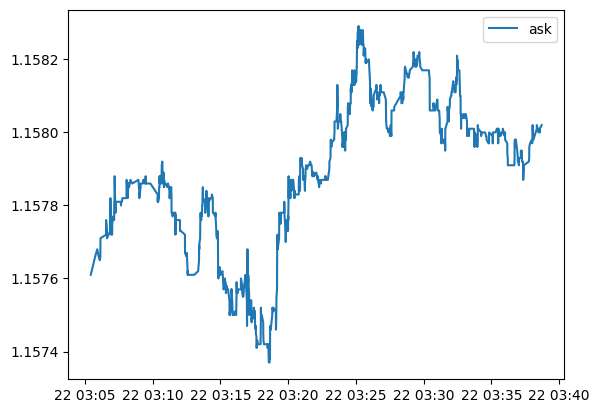

In [32]:
plt.plot(ts, asks, label='ask' )
# plt.plot(bids, x, label='bid')
plt.legend()
plt.show()

DatetimeIndex(['2018-08-22 03:05:25.665000', '2018-08-22 03:05:45.097000',
               '2018-08-22 03:05:49.701000', '2018-08-22 03:05:54.514000',
               '2018-08-22 03:06:00.722000', '2018-08-22 03:06:05.330000',
               '2018-08-22 03:06:05.930000', '2018-08-22 03:06:08.136000',
               '2018-08-22 03:06:08.338000', '2018-08-22 03:06:08.543000',
               ...
               '2018-08-22 03:38:05.545000', '2018-08-22 03:38:05.744000',
               '2018-08-22 03:38:20.567000', '2018-08-22 03:38:20.771000',
               '2018-08-22 03:38:24.780000', '2018-08-22 03:38:27.785000',
               '2018-08-22 03:38:33.593000', '2018-08-22 03:38:33.995000',
               '2018-08-22 03:38:34.199000', '2018-08-22 03:38:42.299000'],
              dtype='datetime64[ns]', length=1130, freq=None)

Price('1.15829')